In [200]:
import os
import sys

sys.path.append(os.path.expanduser("~/mhw_stressviz/analysis/"))
from physiology import tpc

import xarray as xr
import numpy as np
import zarr

import pandas as pd

import s3fs
import gcsfs
import boto3

from importlib import reload
reload(tpc); reload(load)

import matplotlib
import matplotlib.pyplot as plt

import itertools
from functools import partial

from dask.distributed import Client

import cartopy.crs as ccrs
import cartopy.feature as cf

GCP_PROJECT_ID = '170771369993'
OISST_GCP = 'oisst/oisst.zarr'

%matplotlib inline

In [201]:
dask_client = Client()
dask_client

Client Scheduler: tcp://127.0.0.1:37767 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.45 GB


# Verify generated MHWs + Properties

In [202]:
# Load SST
fs = gcsfs.GCSFileSystem(project=GCP_PROJECT_ID, token="../gc-pangeo.json")
oisst = xr.open_zarr(fs.get_mapper(OISST_GCP))
oisst = oisst.assign_coords(lon=(((oisst.lon + 180) % 360) - 180)).sortby('lon')

In [239]:
# Slice to PNW
PNW_LAT = slice(30, 60)
PNW_LON = slice(-155.9, -120.9)
oisst_pnw = oisst.sel(lat = PNW_LAT, lon = PNW_LON).persist()

In [205]:
# Load MHWs
awsfs = s3fs.S3FileSystem()
mhw_mapper = s3fs.S3Map("s3://mhw-stress/new", s3=awsfs)

In [206]:
mhws = xr.open_zarr(mhw_mapper)

In [208]:
mhws

<xarray.Dataset>
Dimensions:               (lat: 120, lon: 140, time: 13636)
Coordinates:
  * lat                   (lat) float32 30.125 30.375 30.625 ... 59.625 59.875
  * lon                   (lon) float64 -155.9 -155.6 -155.4 ... -121.4 -121.1
  * time                  (time) datetime64[ns] 1981-09-01 ... 2018-12-31
Data variables:
    clim                  (lat, lon, time) float64 dask.array<chunksize=(10, 10, 13636), meta=np.ndarray>
    duration              (lat, lon, time) float64 dask.array<chunksize=(10, 10, 13636), meta=np.ndarray>
    index_end             (lat, lon, time) float64 dask.array<chunksize=(10, 10, 13636), meta=np.ndarray>
    index_peak            (lat, lon, time) float64 dask.array<chunksize=(10, 10, 13636), meta=np.ndarray>
    index_start           (lat, lon, time) float64 dask.array<chunksize=(10, 10, 13636), meta=np.ndarray>
    intensity_cumulative  (lat, lon, time) float64 dask.array<chunksize=(10, 10, 13636), meta=np.ndarray>
    intensity_max         (lat, lon, time) float64 dask.array<chunksize=(10, 10, 13636), meta=np.ndarray>
    intensity_mean        (lat, lon, time) float64 dask.array<chunksize=(10, 10, 13636), meta=np.ndarray>
    intensity_var         (lat, lon, time) float64 dask.array<chunksize=(10, 10, 13636), meta=np.ndarray>
    mhw                   (lat, lon, time) float64 dask.array<chunksize=(10, 10, 13636), meta=np.ndarray>
    rate_decline          (lat, lon, time) float64 dask.array<chunksize=(10, 10, 13636), meta=np.ndarray>
    rate_onset            (lat, lon, time) float64 dask.array<chunksize=(10, 10, 13636), meta=np.ndarray>

## Make some Plots
We'll look at the 2014-2015 anomaly in the PNW

In [209]:
date_range = slice("2014-01-01", "2015-12-31")

In [210]:
mhw_pnw = mhws.sel(time=date_range)
sst_mhw_pnw = oisst_pnw.sel(time=date_range)

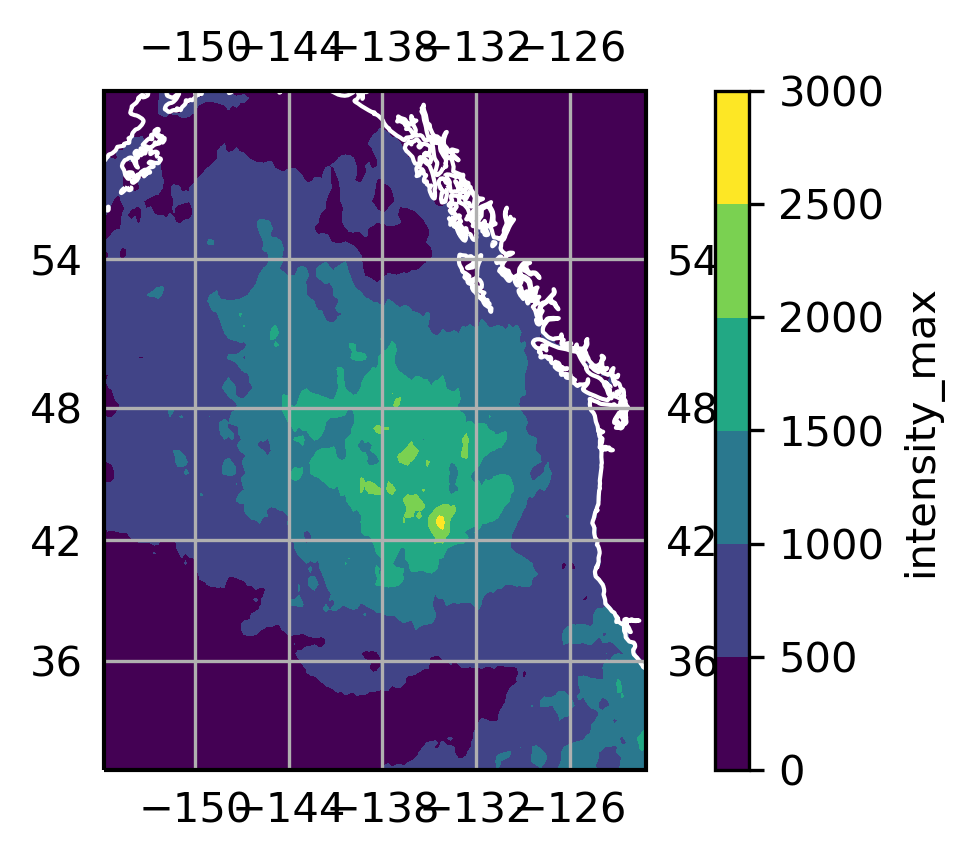

In [255]:
plt.figure(figsize=(6,3), dpi=300)
ax = plt.axes(projection=ccrs.Mercator.GOOGLE)
mhw_pnw.intensity_max.sum(dim='time').plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.add_feature(cf.NaturalEarthFeature('physical','coastline', '50m'), facecolor='none', edgecolor='white')
ax.gridlines(draw_labels=True)

In [256]:
specific_loc = {'lat': -134., "lon": 45.0}


In [258]:
starts = np.unique(mhw_pnw.sel(**specific_loc, method='nearest').index_start.values)
ends = np.unique(mhw_pnw.sel(**specific_loc, method='nearest').index_end.values)
events = np.array(list(itertools.zip_longest(starts, ends, fillvalue=np.nan)))

In [259]:
sorted_events = np.diff(events, axis=1).argsort(axis=0)[::-1]

In [260]:
longest_event = events[np.diff(events, axis=1).argsort()[::-1][0]]

In [328]:
this_event = int(sorted_events[1].squeeze())

In [329]:
startdate_actual = mhws.time[events[this_event][0].astype('int')]
enddate_actual =  mhws.time[events[this_event][1].astype('int')]

In [330]:
startdate = mhws.time[events[this_event][0].astype('int')] - np.timedelta64(90, 'D')
enddate = mhws.time[events[this_event][1].astype('int')] + np.timedelta64(90, 'D')

In [331]:
this_region = mhw_pnw.sel(**specific_loc, method='nearest')
this_region_sst = oisst_pnw.sel(
    time=slice(startdate, enddate), 
    lat=slice(this_region.lat.min(), this_region.lat.max()), 
    lon=slice(this_region.lon.min(), this_region.lon.max())
)


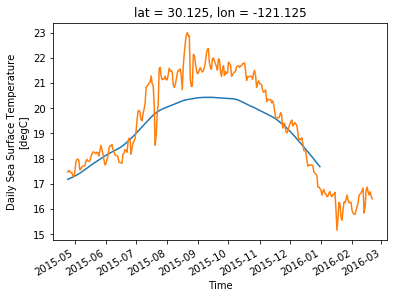

In [332]:
this_region.clim.sel(time=slice(startdate, enddate)).plot()
oisst_pnw.sel(time=slice(startdate, enddate), lat=slice(this_region.lat.min(), this_region.lat.max()))
this_region_sst.sst.plot()

## Appendix: bring in phyto

In [333]:
plankton = pd.read_csv("../data/Phytoplankton_temperature_growth_rate_dataset_2016_01_29/traits_derived_2016_01_29.csv", engine='python')

In [334]:
plankton.habitat.unique()

array(['marine', 'saline lake', 'freshwater', 'estuarine', 'hot spring',
       'salt marsh', 'unknown'], dtype=object)

In [335]:
plankton = plankton[
    (plankton.curvequal == 'good') &
    (plankton.habitat.isin([
        'marine',
        'estuarine',
        'salt marsh',
        'unknown'
    ]))
]
len(plankton)

118

In [336]:
this_phyla = plankton[plankton.phylum == 'Dinophyta']

In [337]:
median_phyla = this_phyla.median()

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [338]:
s = median_phyla
this_det = partial(tpc.perf_det, T_opt = s['mu.g.opt.list'], tpc = partial(tpc.tpc, a=s['mu.alist'], b=s['mu.blist'], z=s['mu.c.opt.list'], w=s['mu.wlist']))

In [339]:
this_det

functools.partial(<function perf_det at 0x7f26fc0c3560>, T_opt=23.360930879999998, tpc=functools.partial(<function tpc at 0x7f26be0cf440>, a=0.11851687, b=0.0609348075, z=19.873774920000002, w=21.70944274))

In [340]:
det_loc = this_det(
    oisst_pnw.sel(time = slice(startdate, enddate), lat=this_region.lat, lon=this_region.lon).sst.values
)

In [341]:
clim_det = this_det(
    this_region.clim.sel(time=slice(startdate, enddate)).values
)

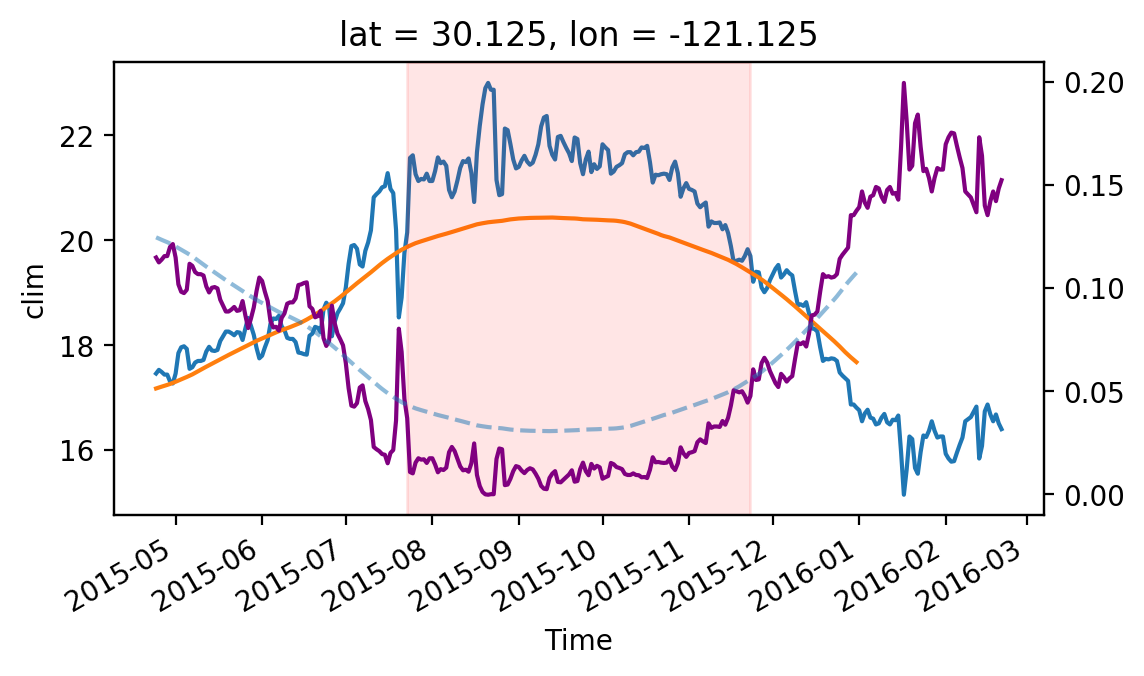

In [342]:
plt.figure(figsize=(6,3), dpi=200)
ax = plt.axes()
# regional_mean_thresh.plot(ax=ax)
# regional_mean_sst.plot(ax=ax)
oisst_pnw.sel(time = slice(startdate, enddate), lat=this_region.lat, lon=this_region.lon).sst.plot(ax=ax)
this_region.clim.sel(time=slice(startdate, enddate)).plot()

ax1 = ax.twinx()

plt.axvspan(startdate_actual.values, enddate_actual.values, alpha=0.1, color='red')


ax1.plot(oisst_pnw.sel(time = slice(startdate, enddate), lat=this_region.lat, lon=this_region.lon).sst.time, det_loc, color='purple')
ax1.plot(this_region.clim.sel(time=slice(startdate, enddate)).time, clim_det, linestyle='--', alpha=0.5)
# ax1.set_ylim([0, 0])

In [1]:
this_region.mhw

NameError: name 'this_region' is not defined